# Εργασία 3

## Α. Ομαδοποίηση χειρόγραφων ψηφίων της MNIST

### 1. Preprocessing

Τα δεδομένα περιέχονται στο αρχείο mnist_all.mat. Το διάβασμα του αρχείου γίνεται με την συνάρτηση scipy.io.loadmat η οποία επιστρέφει ένα dictionary το οποίο έχει κλειδια τα 'train0', 'train1', 'train2',... και 'test0', 'test1', 'test2',... και data τις εικόνες των αντίστοιχων ψηφίων.

In [1]:
import urllib.request
import numpy as np
import scipy.io
import os

np.random.seed(0)

url = 'https://cs.nyu.edu/~roweis/data/mnist_all.mat'
filename = 'mnist_all.mat'

if not os.path.exists(filename):
    print('Downloading file...')
    urllib.request.urlretrieve(url, filename)
    print('Done.')

mat = scipy.io.loadmat(filename)
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'train0', 'test0', 'train1', 'test1', 'train2', 'test2', 'train3', 'test3', 'train4', 'test4', 'train5', 'test5', 'train6', 'test6', 'train7', 'test7', 'train8', 'test8', 'train9', 'test9'])

Οι εικόνες των ψηφίων έχουν μέγεθος 784 = 28x28.

In [2]:
digit = mat['train2'][0]
digit.shape

(784,)

Παρακάτω φαίνονται οι εικόνες πέντε ψηφίων.

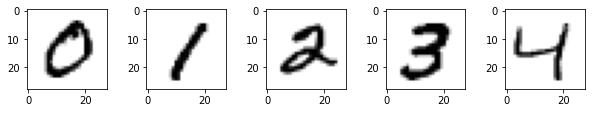

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

n = 5
fig, axs = plt.subplots(1, n, figsize=(10, 10))
plt.subplots_adjust(wspace=0.5)
for i in range(n):
    digit = mat['train' + str(i)][0]
    digit = digit.reshape((28, 28))
    axs[i].imshow(digit, cmap=plt.cm.binary)
plt.show()

Οι είκονες και οι ετικέτες φορτώνονται σε numpy arrays. Το μέγεθος του training set είναι 20000 και του test set 10000. Η κανονικοποίηση στο διάστημα [0, 1] γίνεται με διαίρεση με το 255 το οποίο είναι η μέγιστη τιμή της φωτεινότητας ενός pixel.

In [4]:
x_train, y_train, x_test, y_test = [], [], [], []

for key, data in mat.items():
    if 'train' in key:
        for x in data[:100]:
            x_train.append(x)
            num = int(key[-1])
            y_train.append(num)
    if 'test' in key:
        for x in data:
            x_test.append(x)
            num = int(key[-1])
            y_test.append(num)

x_train = np.array(x_train, dtype=np.double)
y_train = np.array(y_train, dtype=np.double)
x_test = np.array(x_test, dtype=np.double)
y_test = np.array(y_test, dtype=np.double)
x_train_original = x_train
x_test_original = x_test

print('x_train.shape =', x_train.shape)
print('y_train.shape =', y_train.shape)
print('x_test.shape =', x_test.shape)
print('y_test.shape =', y_test.shape)

x_train.shape = (1000, 784)
y_train.shape = (1000,)
x_test.shape = (10000, 784)
y_test.shape = (10000,)


In [5]:
x_train /= 255.
x_test /= 255.

print()
print('x_train is in [{}, {}]'.format(np.min(x_train), np.max(x_train)))
print('x_test is in [{}, {}]'.format(np.min(x_test), np.max(x_test)))


x_train is in [0.0, 1.0]
x_test is in [0.0, 1.0]


Παρακάτω βλέπουμε το ιστόγραμμα των ψηφίων στο training set.

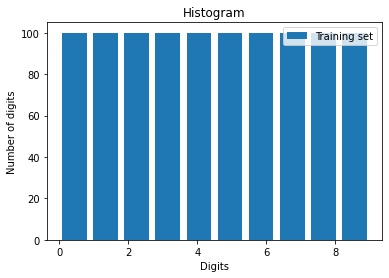

In [6]:
plt.hist(y_train, label='Training set', rwidth=0.8)
plt.title('Histogram')
plt.ylabel('Number of digits')
plt.xlabel('Digits')
plt.legend()
plt.show()

### 2. Embedding

Ακολουθεί εφαρμογή διάφορων embeddings: Spectral, Standard LLE, Modified LLE, Isomap και t-SNE με τα οποία μετασχηματίζονται τα δεδομένα σε χώρο μικρότερης διάστασης.

embedding = Spectral, time = 0.5 sec
embedding = LLE, time = 0.7 sec
embedding = Isomap, time = 1.1 sec
embedding = t-SNE, time = 2.4 sec


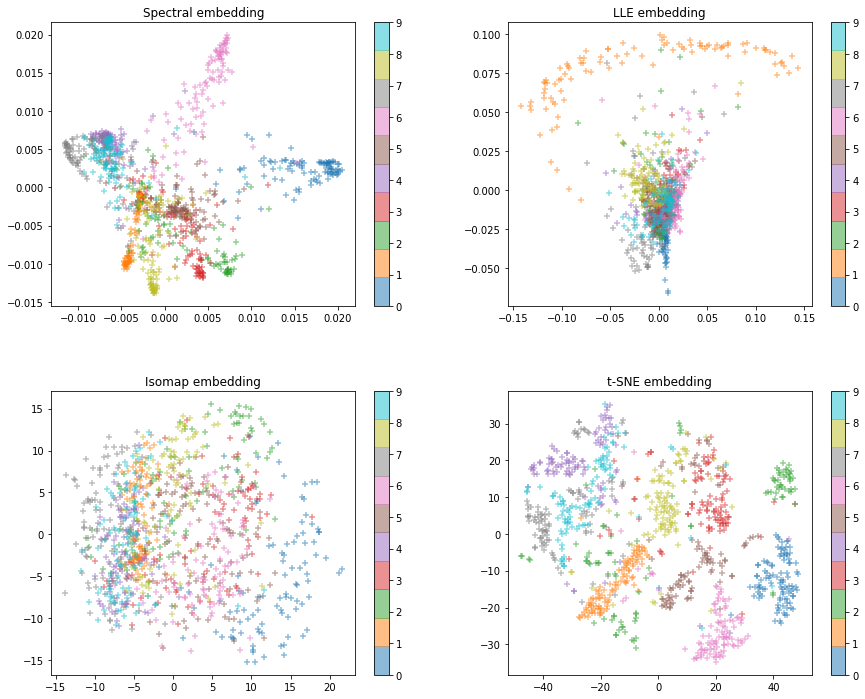

In [7]:
from sklearn.manifold import SpectralEmbedding, LocallyLinearEmbedding, Isomap, TSNE
from time import time

embeddings = [
    ('Spectral', SpectralEmbedding(n_components=2, n_neighbors=20, random_state=0, n_jobs=-1)),
    ('LLE', LocallyLinearEmbedding(n_components=2, n_neighbors=20, n_jobs=-1)),
    ('Isomap', Isomap(n_components=2, n_neighbors=20, n_jobs=-1)),
    ('t-SNE', TSNE(n_components=2, random_state=0, n_jobs=-1)),
]

plt.subplots(2, 2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.3)

x_train_embedded_dict = {}

for i, (embedding_str, embedding) in enumerate(embeddings):
    t1 = time()
    x_train_embedded = embedding.fit_transform(x_train)
    t2 = time()
    x_train_embedded_dict[embedding_str] = x_train_embedded
    plt.subplot(2, 2, i+1)
    plt.title('{} embedding'.format(embedding_str))
    plt.scatter(x_train_embedded[:, 0], x_train_embedded[:, 1],
                c=y_train, cmap='tab10', marker='+', alpha=0.5)
    plt.colorbar()
    print('embedding = {}, time = {:.1f} sec'.format(embedding_str, t2-t1))
    
plt.show()

Επιλέγουμε να προχωρήσουμε με το t-SNE γιατί μας δίνει αρκετά καλά διαχωρισμένες κλάσεις.

In [8]:
x_train_embedded = x_train_embedded_dict['t-SNE']

### 3. Algorithms

#### 3.1 MySpectralClustering

In [9]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

class MySpectralClustering(object):
    def __init__(self, n_clusters=8, random_state=None, n_neighbors=10, method='normalized_sym', n_jobs=None):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.n_neighbors = n_neighbors
        self.method = method
        self.n_jobs = n_jobs
        self.lambdas = None
        self.laplacian = None
        
    def set_params(self, **params):
        if not params: return self
        self.n_clusters = params.get('n_clusters', self.n_clusters)
        self.random_state = params.get('random_state', self.random_state)
        self.n_neighbors = params.get('n_neighbors', self.n_neighbors)
        self.method = params.get('method', self.method)
        self.n_jobs = params.get('n_jobs', self.n_jobs)
        return self
    
    def fit_predict(self, X):
        nn = NearestNeighbors(n_neighbors=self.n_neighbors, n_jobs=self.n_jobs)
        nn.fit(X)
        G = nn.kneighbors_graph(X)
        S = 0.5*(G + G.T)
        d = np.sum(S, axis=0)
        
        D_inv = np.diagflat(d)
        L = D_inv - S
        if self.method == 'unnormalized':
            pass
        elif self.method == 'normalized_rw':
            L = D_inv @ L
        elif self.method == 'normalized_sym':
            D_inv_sqrt = np.diagflat(1/np.sqrt(d))
            L = D_inv_sqrt @ L @ D_inv_sqrt
        else:
            raise Exception('Invalid method = {}'.format(self.method))
        
        self.laplacian = L
            
        w, v = scipy.linalg.eigh(L)
        indices = np.argsort(w)
        self.lambdas = w[indices]
        v = v[:, indices]        
        v = v[:, :self.n_clusters]
        
        if self.method == 'normalized_sym':
            v = D_inv_sqrt @ v
        
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        labels = kmeans.fit_predict(v)
        
        return labels

### 4. Clustering

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import homogeneity_completeness_v_measure
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import NearestCentroid
from sklearn.utils import shuffle

def do_the_clustering(clustering, X, y, verbose=0):
    all_n_clusters = range(2, 18)
    experiments_num = len(all_n_clusters)
    homogeneity = np.zeros(experiments_num)
    completeness = np.zeros(experiments_num)
    v_measure = np.zeros(experiments_num)
    times = np.zeros(experiments_num)
    accuracy = np.zeros(experiments_num)
    recall = np.zeros(experiments_num)
    precision = np.zeros(experiments_num)
    f1 = np.zeros(experiments_num)
    all_examples = []
    most_frequent_labels = []
    cm = None

    plt.subplots(8, 2, figsize=(15, 40))
    plt.subplots_adjust(hspace=0.3)
    
    for i, n_clusters in enumerate(all_n_clusters):
        clustering.set_params(n_clusters=n_clusters)
        t1 = time()
        y_pred = clustering.fit_predict(X)
        t2 = time()
        times[i] = t2 - t1
        homogeneity[i], completeness[i], v_measure[i] = homogeneity_completeness_v_measure(y, y_pred)        
        plt.subplot(8, 2, i+1)
        plt.title('n_clusters = {}'.format(n_clusters))
        plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='tab10', marker='+', alpha=0.5)
        plt.colorbar()
        if verbose > 0:
            print('n_clusters = {}, time = {:.1f} sec'.format(n_clusters, times[i]))
        
        y_train_new = np.copy(y_pred)       
        for label in range(n_clusters):
            indices = (y_pred == label)
            counts = np.bincount(y.astype(int)[indices])
            val = np.argmax(counts)
            y_train_new[indices] = val
            
            if n_clusters == 10:
                x_examples = x_train_original[y_pred == label]
                x_examples = shuffle(x_examples, random_state=0)
                all_examples.append(x_examples[:10])
                most_frequent_labels.append(val)
        
        clf = NearestCentroid()
        clf.fit(x_train, y_train_new)
        y_pred_test = clf.predict(x_test)
        accuracy[i] = accuracy_score(y_test, y_pred_test)
        precision[i] = precision_score(y_test, y_pred_test, average='weighted', zero_division=0)
        recall[i] = recall_score(y_test, y_pred_test, average='weighted')
        f1[i] = f1_score(y_test, y_pred_test, average='weighted')
        
        if n_clusters == 10:
            cm = confusion_matrix(y_test, y_pred_test)
 
    plt.show()
    
    if hasattr(clustering, 'lambdas'):
        lambdas = clustering.lambdas
    else:
        lambdas = None
    
    results = {
        'all_n_clusters': all_n_clusters,
        'homogeneity': homogeneity,
        'completeness': completeness,
        'v_measure': v_measure,
        'times': times,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cm': cm,
        'lambdas': lambdas,
        'all_examples': all_examples,
        'most_frequent_labels': most_frequent_labels,
    }
    
    return results

In [11]:
def plot_clustering_results(results):
    all_n_clusters = results['all_n_clusters']
    homogeneity = results['homogeneity']
    completeness = results['completeness']
    v_measure = results['v_measure']
    times = results['times']
    
    plt.subplots(1, 2, figsize=(15, 5))
    plt.subplots_adjust(wspace=0.4)
    
    plt.subplot(1, 2, 1)
    plt.title('Clustering scores')
    plt.plot(all_n_clusters, homogeneity, label='Homogeneity')
    plt.plot(all_n_clusters, completeness, label='Completeness')
    plt.plot(all_n_clusters, v_measure, label='V-Measure')
    plt.ylabel('Score')
    plt.xlabel('n_clusters')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.title('Clustering time')
    plt.plot(all_n_clusters, times)
    plt.ylabel('Time (sec)')
    plt.xlabel('n_clusters')
    plt.show()

In [12]:
import seaborn as sns

def plot_classification_results(results):
    all_n_clusters = results['all_n_clusters']
    accuracy = results['accuracy']
    precision = results['precision']
    recall = results['recall']
    f1 = results['f1']
    cm = results['cm']
    
    plt.subplots(1, 2, figsize=(15, 5))
    plt.subplots_adjust(wspace=0.4)
    plt.subplot(1, 2, 1)
    plt.title('Classification scores')
    plt.plot(all_n_clusters, accuracy, label='Accuracy')
    plt.plot(all_n_clusters, precision, label='Precision')
    plt.plot(all_n_clusters, recall, label='Recall')
    plt.plot(all_n_clusters, f1, label='F1')
    plt.ylabel('Score')
    plt.xlabel('n_clusters')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.title('Confusion matrix for n_clusters = 10')
    sns.heatmap(cm, cmap="Oranges") # FIXME
    plt.show()

In [13]:
def plot_eigvals(results):
    lambdas = results['lambdas']
    
    plt.title('Eigenvalues')
    lambdas = lambdas[:30]
    plt.plot(np.arange(1, len(lambdas)+1), lambdas, '+')
    plt.show()

In [14]:
from IPython.display import display, HTML
import pandas as pd

def display_scores(results):
    all_n_clusters = results['all_n_clusters']
    homogeneity = results['homogeneity']
    completeness = results['completeness']
    v_measure = results['v_measure']
    accuracy = results['accuracy']
    precision = results['precision']
    recall = results['recall']
    f1 = results['f1']    
    
    df = pd.DataFrame(list(zip(all_n_clusters, homogeneity, completeness, v_measure,
                           accuracy, precision, recall, f1)),
                  columns=('n_clusters', 'Homogeneity', 'Completeness', 'V-Measure',
                           'Accuracy', 'Precision', 'Recall', 'F1'))
    display(HTML(df.to_html(index=False)))

In [15]:
def plot_clustering_examples(results):
    all_examples = results['all_examples']
    most_frequent_labels = results['most_frequent_labels']
    
    print('Clustering examples for n_clusters = 10')
    print()
    for label, examples in enumerate(all_examples):
        print('Examples for cluster {}. Most frequent label is {}.'
              .format(label, most_frequent_labels[label]))
        plt.subplots(1, 10, figsize=(15, 15))
        plt.subplots_adjust(wspace=0.4)
        for i, x_example in enumerate(examples):
            plt.subplot(1, 10, i+1)
            digit = x_example.reshape((28, 28))
            plt.imshow(digit, cmap=plt.cm.binary)
        plt.show()

#### 4.1 My Unnormalized Spectral Clustering

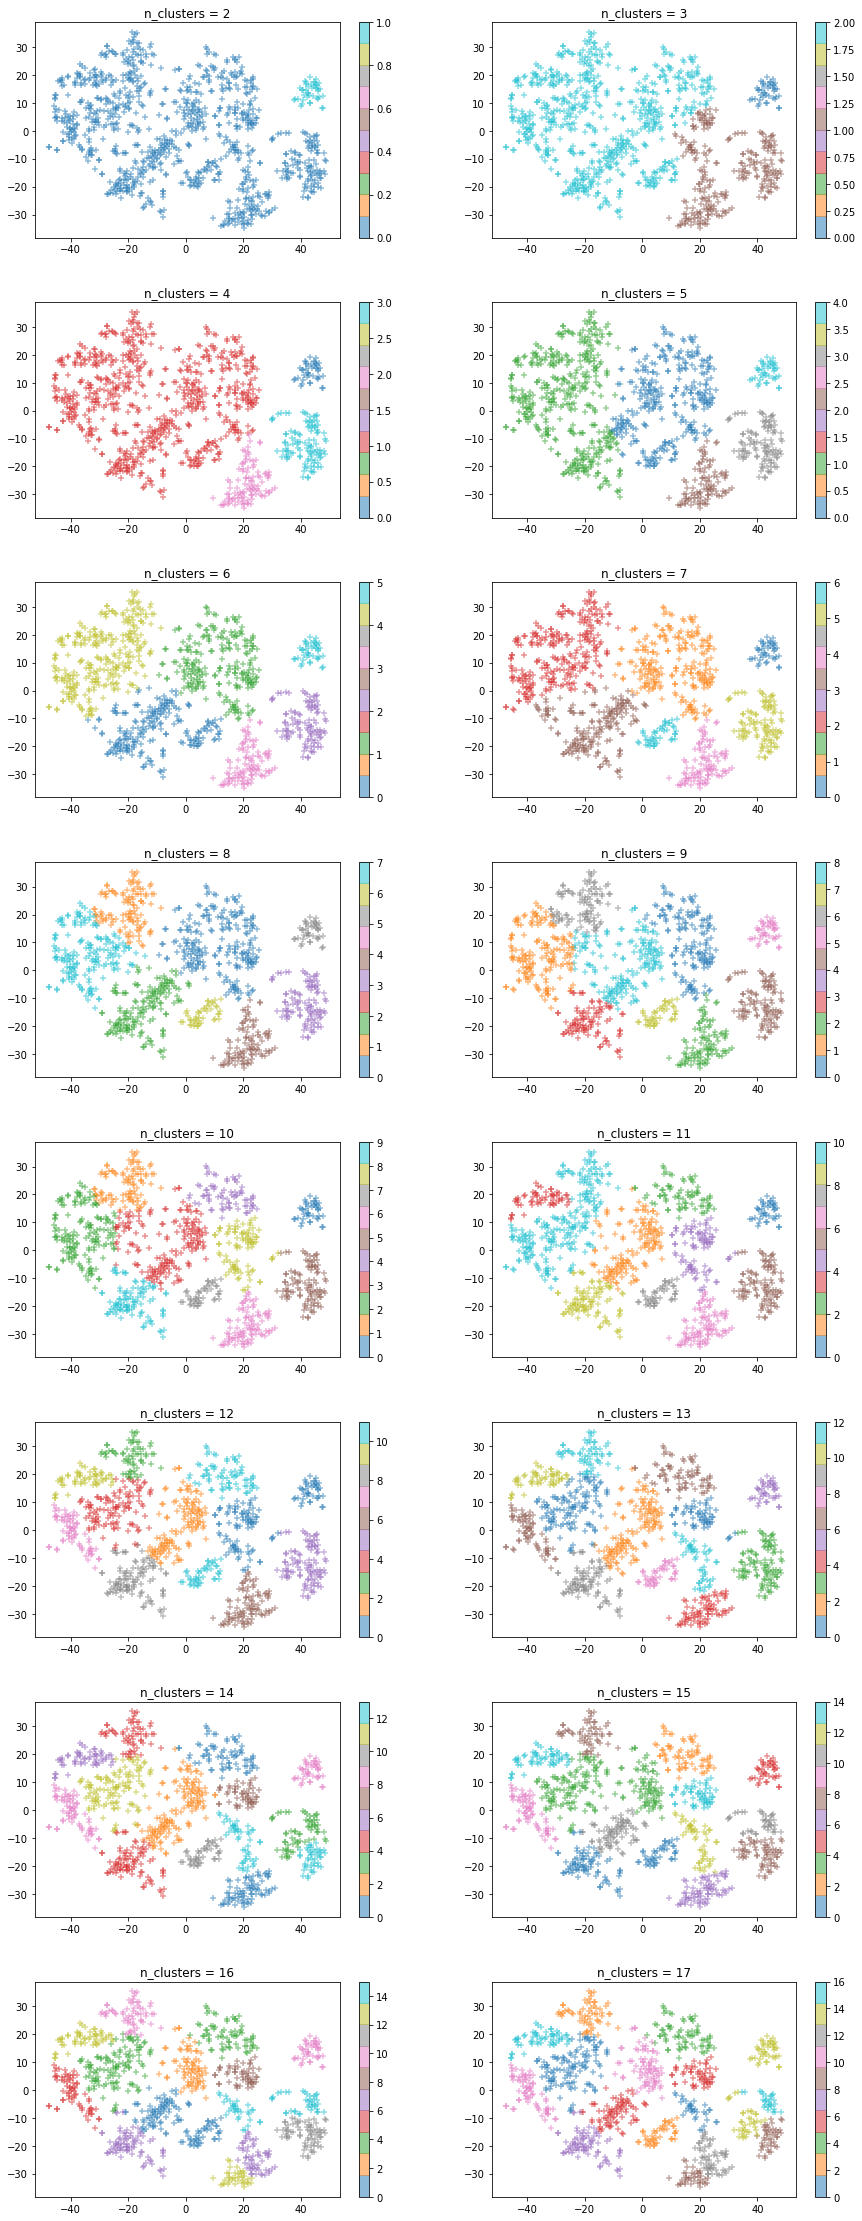

In [16]:
clustering = MySpectralClustering(n_neighbors=20, random_state=0, method='unnormalized', n_jobs=-1)

results = do_the_clustering(clustering, x_train_embedded, y_train)

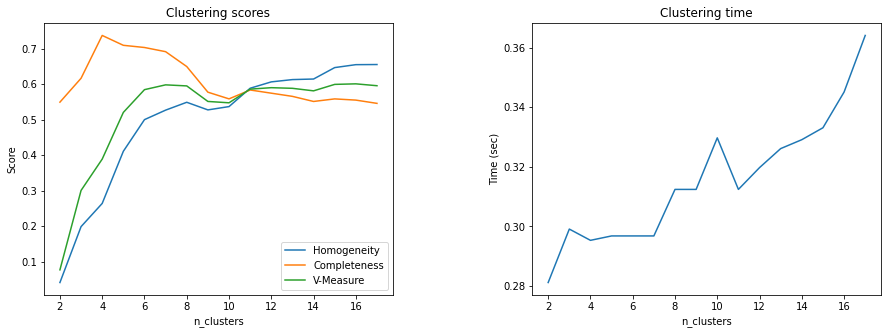

In [17]:
plot_clustering_results(results)

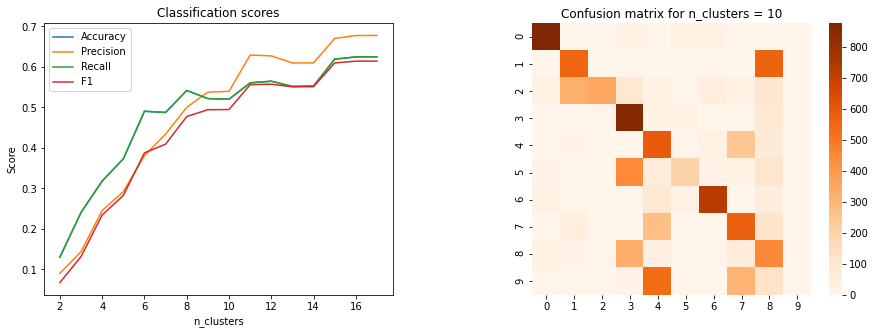

In [18]:
plot_classification_results(results)

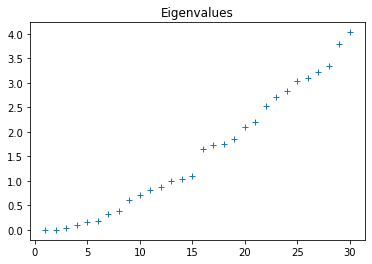

In [19]:
plot_eigvals(results)

In [20]:
display_scores(results)

n_clusters,Homogeneity,Completeness,V-Measure,Accuracy,Precision,Recall,F1
2,0.041583,0.549487,0.077314,0.1307,0.090477,0.1307,0.067764
3,0.199007,0.616718,0.300913,0.2409,0.144080,0.2409,0.131882
4,0.264313,0.737282,0.389126,0.3184,0.245619,0.3184,0.234569
5,0.411095,0.709517,0.520571,0.3731,0.292016,0.3731,0.282623
6,0.500241,0.703364,0.584663,0.4905,0.381076,0.4905,0.387972
7,0.526991,0.691598,0.598177,0.4876,0.434062,0.4876,0.409305
8,0.549123,0.649742,0.595210,0.5418,0.500339,0.5418,0.477589
9,0.527657,0.577552,0.551478,0.5218,0.537703,0.5218,0.494397
10,0.536983,0.558716,0.547634,0.5202,0.539747,0.5202,0.494731
11,0.588626,0.583704,0.586155,0.5607,0.629202,0.5607,0.556229


Clustering examples for n_clusters = 10

Examples for cluster 0. Most frequent label is 2.


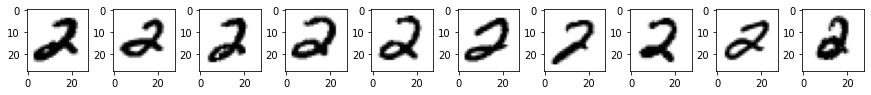

Examples for cluster 1. Most frequent label is 4.


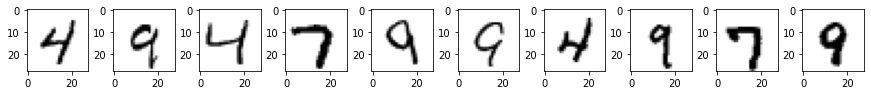

Examples for cluster 2. Most frequent label is 7.


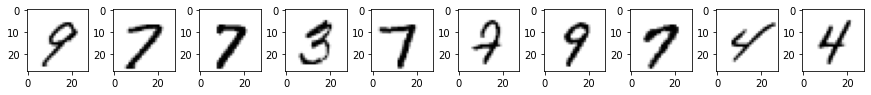

Examples for cluster 3. Most frequent label is 8.


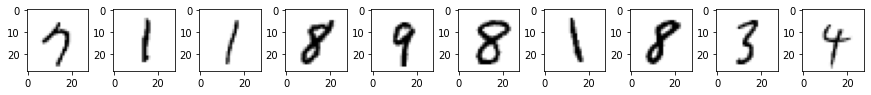

Examples for cluster 4. Most frequent label is 3.


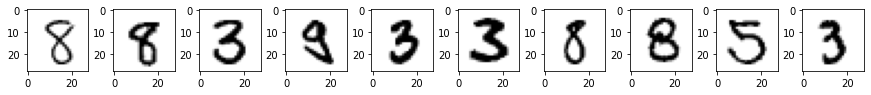

Examples for cluster 5. Most frequent label is 0.


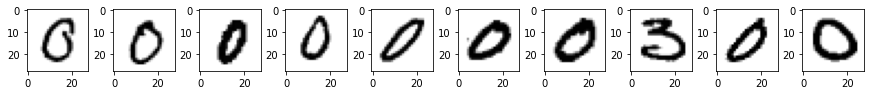

Examples for cluster 6. Most frequent label is 6.


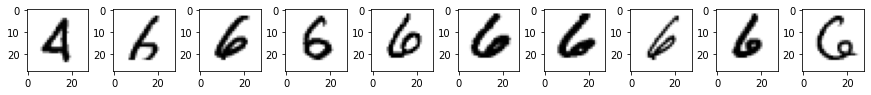

Examples for cluster 7. Most frequent label is 5.


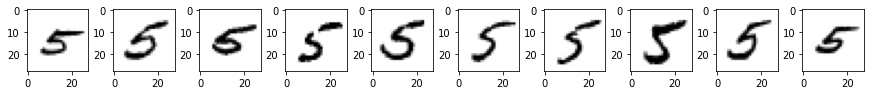

Examples for cluster 8. Most frequent label is 3.


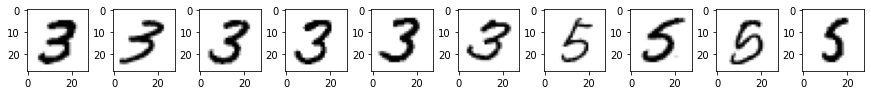

Examples for cluster 9. Most frequent label is 1.


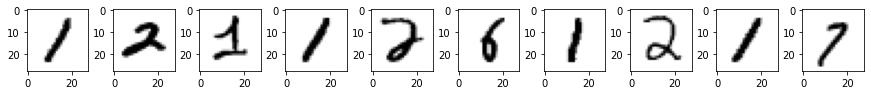

In [21]:
plot_clustering_examples(results)

#### 4.2 My Normalized Spectral Clustering - $L_{rw}$

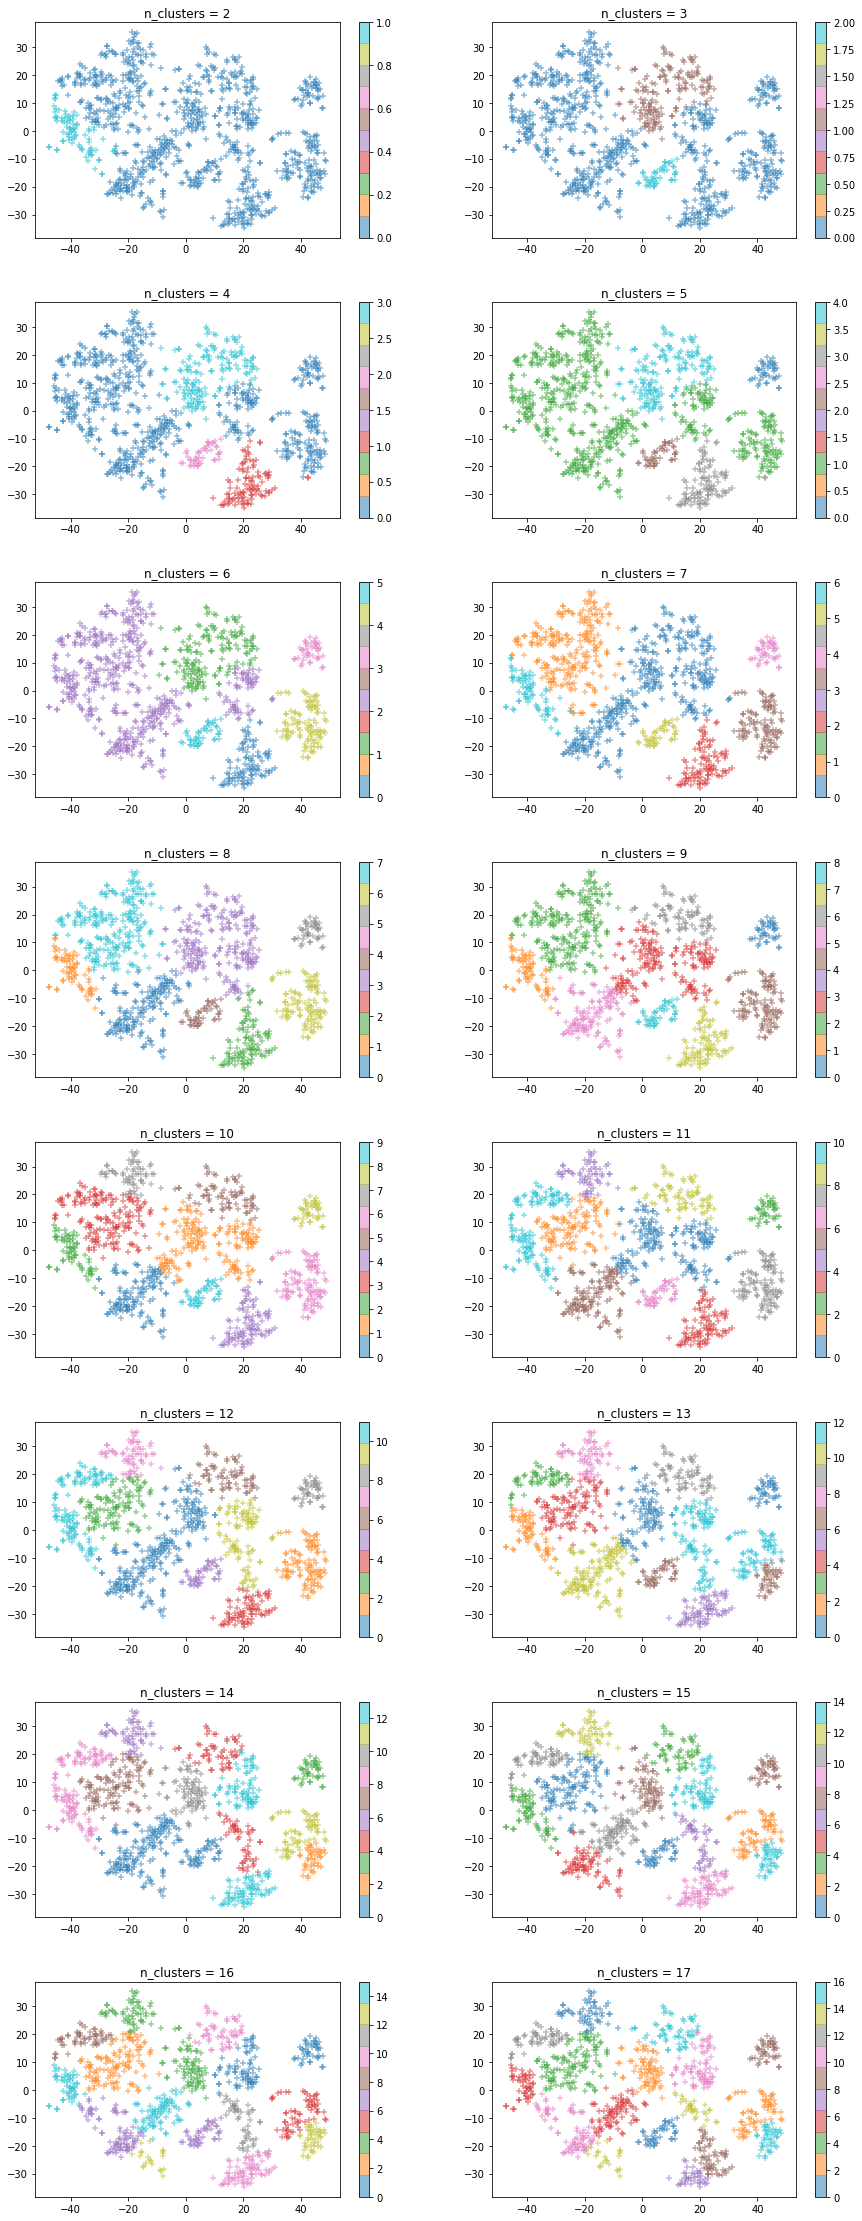

In [22]:
clustering = MySpectralClustering(n_neighbors=20, random_state=0, method='normalized_rw', n_jobs=-1)

results = do_the_clustering(clustering, x_train_embedded, y_train)

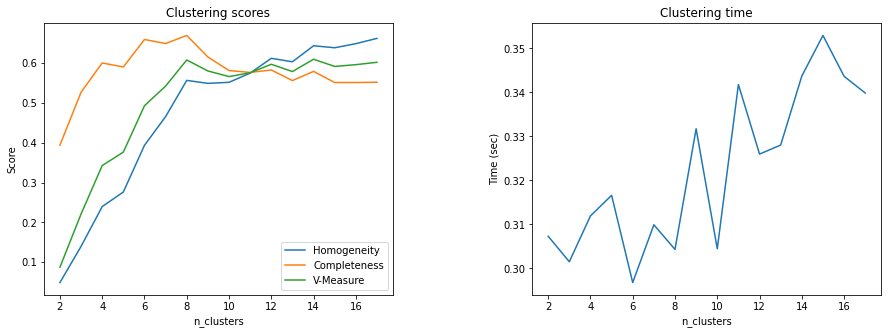

In [23]:
plot_clustering_results(results)

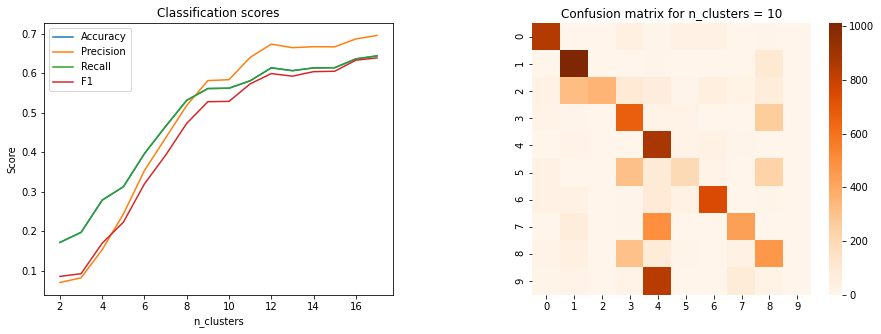

In [24]:
plot_classification_results(results)

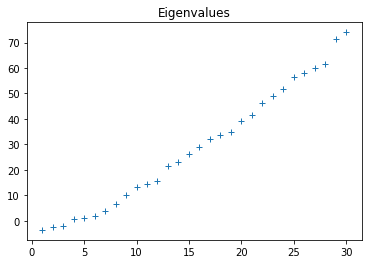

In [25]:
plot_eigvals(results)

In [26]:
display_scores(results)

n_clusters,Homogeneity,Completeness,V-Measure,Accuracy,Precision,Recall,F1
2,0.049307,0.393622,0.087636,0.1719,0.070465,0.1719,0.085917
3,0.139988,0.526463,0.221167,0.1973,0.082370,0.1973,0.092844
4,0.239769,0.599853,0.342598,0.2788,0.153459,0.2788,0.169939
5,0.276320,0.589802,0.376331,0.3125,0.243374,0.3125,0.222915
6,0.393405,0.658727,0.492612,0.3965,0.353733,0.3965,0.319972
7,0.465385,0.648553,0.541909,0.4653,0.435998,0.4653,0.392451
8,0.556185,0.668846,0.607335,0.5312,0.518307,0.5312,0.472975
9,0.548659,0.614799,0.579849,0.5609,0.581017,0.5609,0.527692
10,0.551355,0.580874,0.565729,0.5618,0.583320,0.5618,0.528433
11,0.574365,0.576109,0.575236,0.5805,0.639753,0.5805,0.572749


Clustering examples for n_clusters = 10

Examples for cluster 0. Most frequent label is 1.


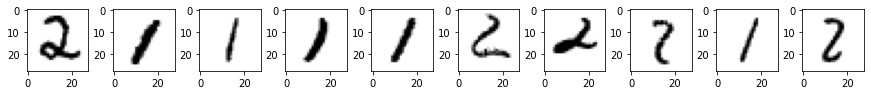

Examples for cluster 1. Most frequent label is 8.


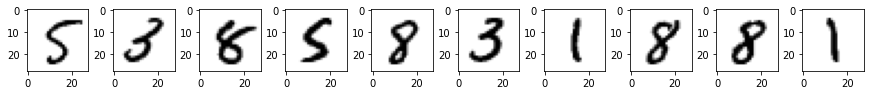

Examples for cluster 2. Most frequent label is 7.


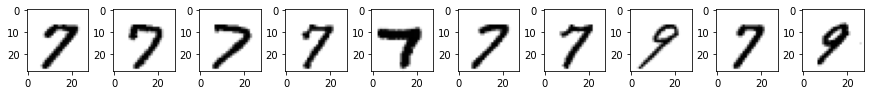

Examples for cluster 3. Most frequent label is 4.


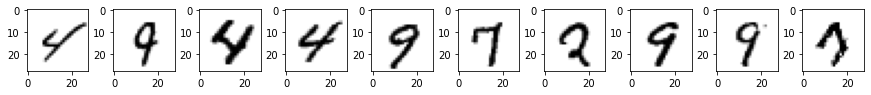

Examples for cluster 4. Most frequent label is 6.


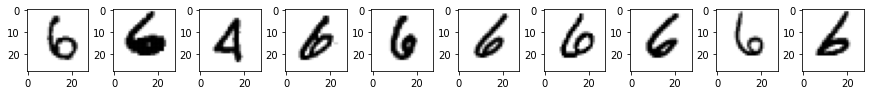

Examples for cluster 5. Most frequent label is 3.


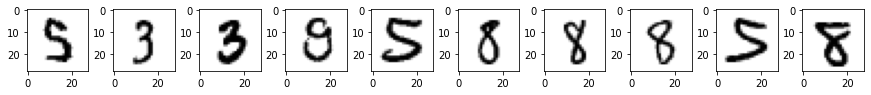

Examples for cluster 6. Most frequent label is 0.


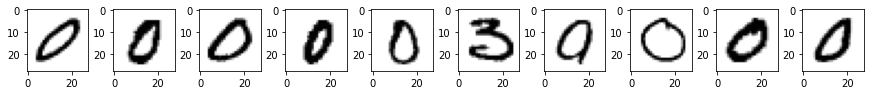

Examples for cluster 7. Most frequent label is 4.


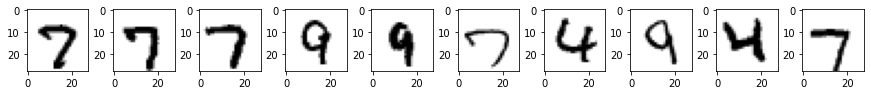

Examples for cluster 8. Most frequent label is 2.


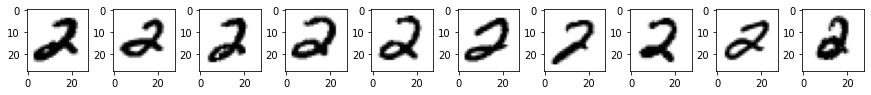

Examples for cluster 9. Most frequent label is 5.


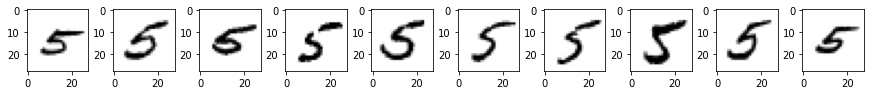

In [27]:
plot_clustering_examples(results)

#### 4.3 My Normalized Spectral Clustering - $L_{sym}$

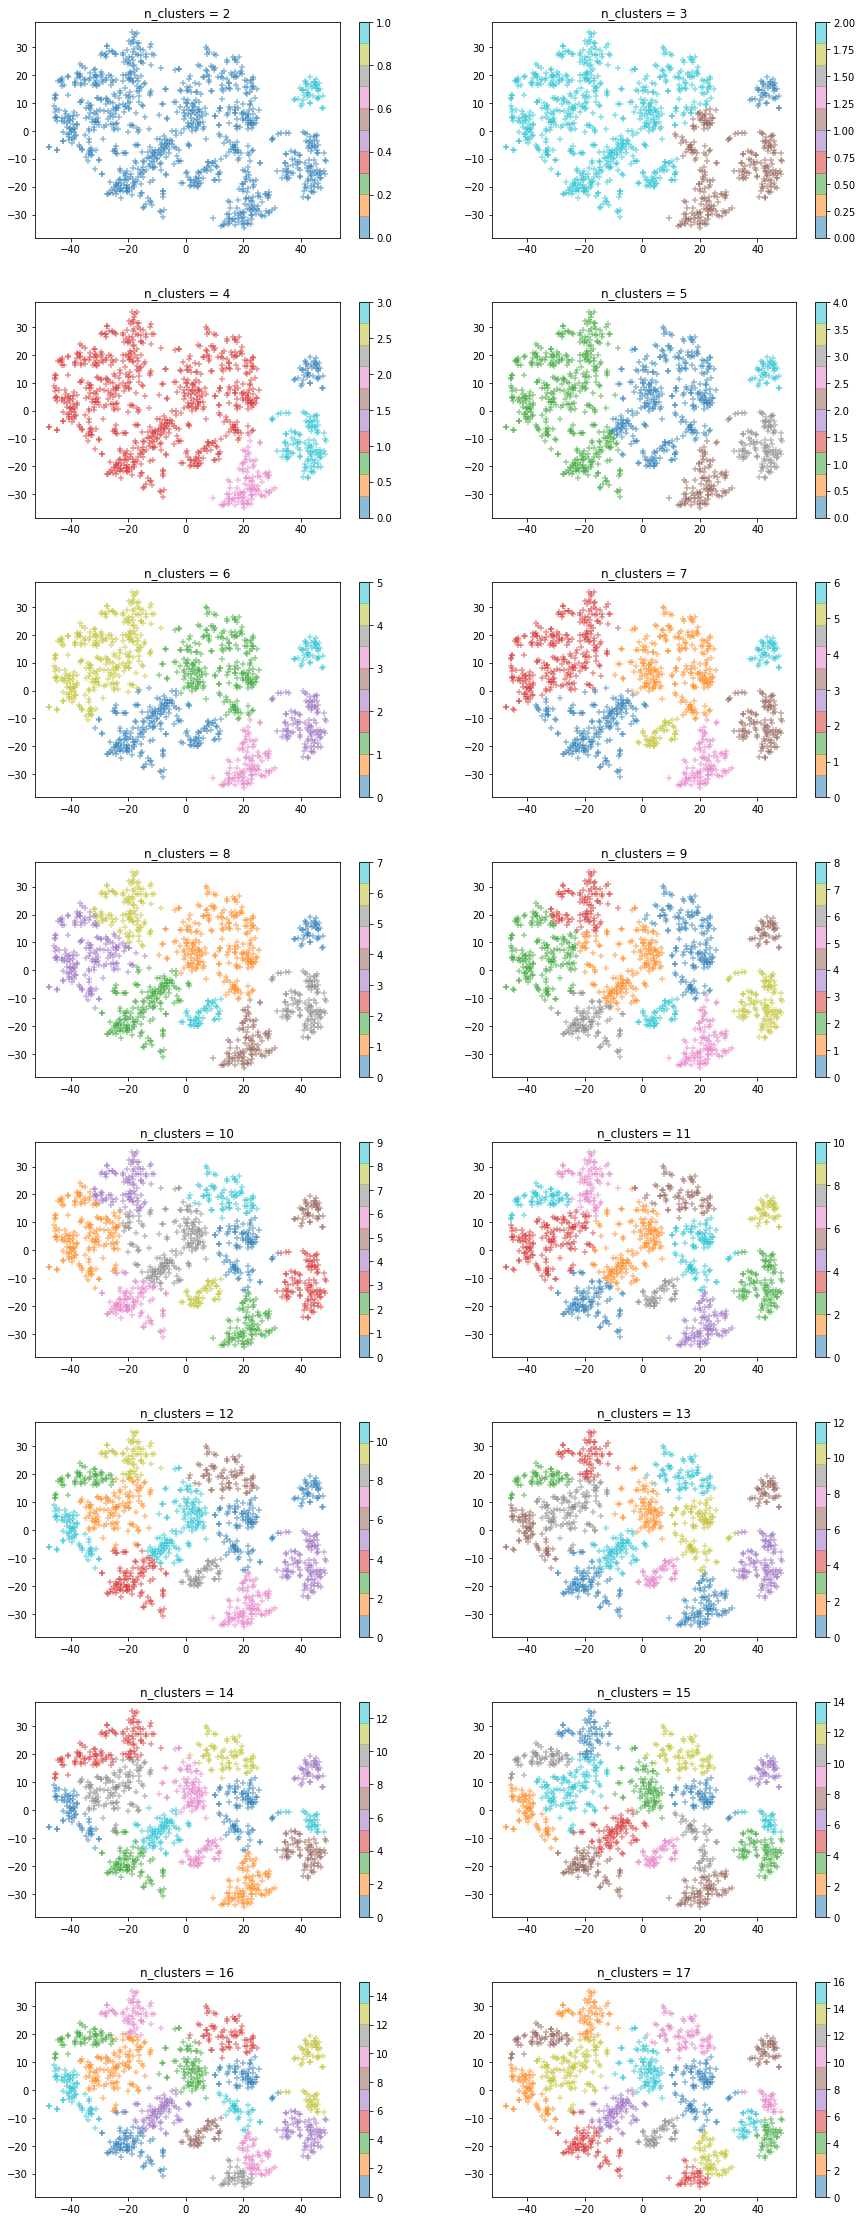

In [28]:
clustering = MySpectralClustering(n_neighbors=20, random_state=0, method='normalized_sym', n_jobs=-1)

results = do_the_clustering(clustering, x_train_embedded, y_train)

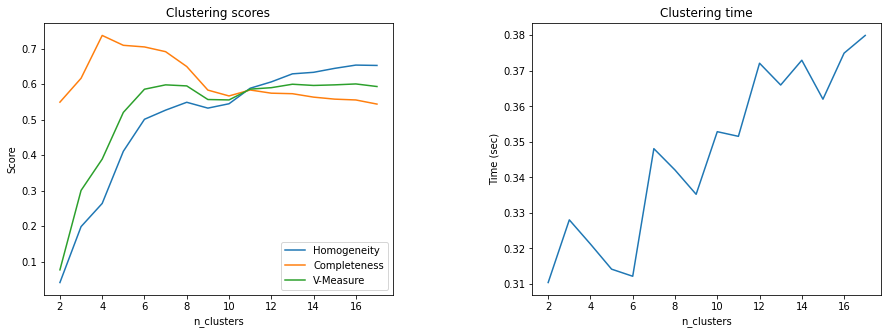

In [29]:
plot_clustering_results(results)

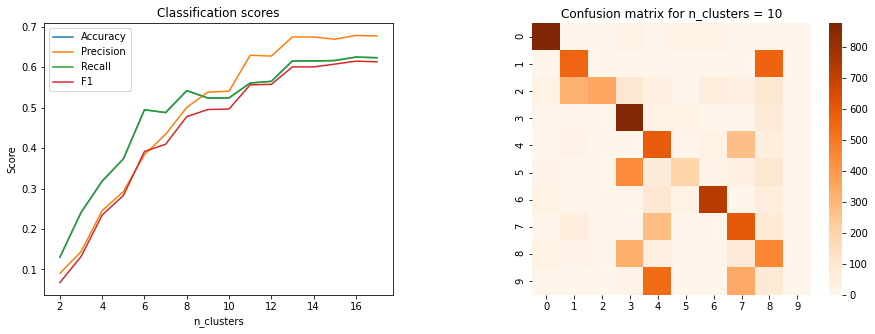

In [30]:
plot_classification_results(results)

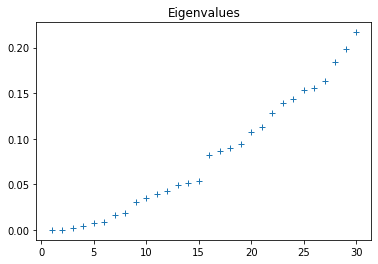

In [31]:
plot_eigvals(results)

In [32]:
display_scores(results)

n_clusters,Homogeneity,Completeness,V-Measure,Accuracy,Precision,Recall,F1
2,0.041583,0.549487,0.077314,0.1307,0.090477,0.1307,0.067764
3,0.199007,0.616718,0.300913,0.2409,0.144080,0.2409,0.131882
4,0.264313,0.737282,0.389126,0.3184,0.245619,0.3184,0.234569
5,0.411095,0.709517,0.520571,0.3731,0.292016,0.3731,0.282623
6,0.501254,0.704933,0.585897,0.4946,0.383788,0.4946,0.391532
7,0.526991,0.691598,0.598177,0.4876,0.434062,0.4876,0.409305
8,0.549123,0.649742,0.595210,0.5418,0.500339,0.5418,0.477589
9,0.532677,0.583398,0.556885,0.5236,0.538128,0.5236,0.495213
10,0.544955,0.566944,0.555732,0.5237,0.540386,0.5237,0.496366
11,0.588626,0.583704,0.586155,0.5607,0.629202,0.5607,0.556229


Clustering examples for n_clusters = 10

Examples for cluster 0. Most frequent label is 3.


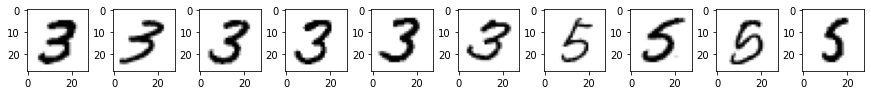

Examples for cluster 1. Most frequent label is 7.


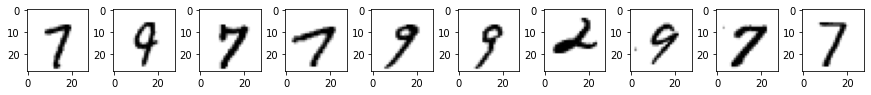

Examples for cluster 2. Most frequent label is 6.


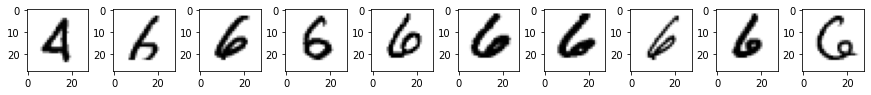

Examples for cluster 3. Most frequent label is 0.


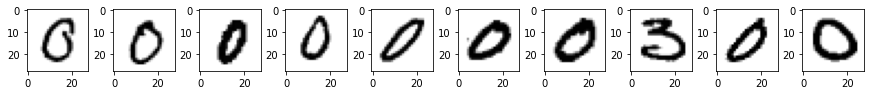

Examples for cluster 4. Most frequent label is 4.


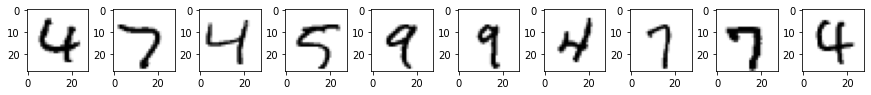

Examples for cluster 5. Most frequent label is 2.


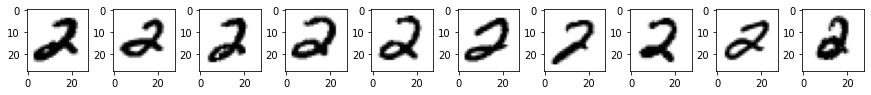

Examples for cluster 6. Most frequent label is 1.


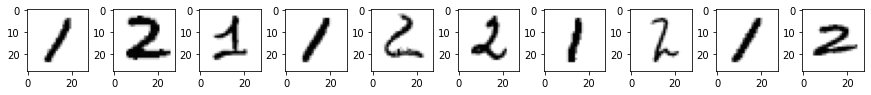

Examples for cluster 7. Most frequent label is 8.


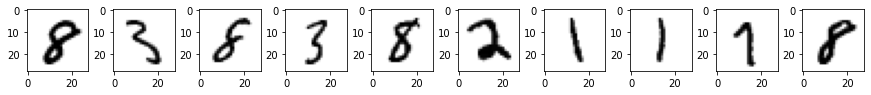

Examples for cluster 8. Most frequent label is 5.


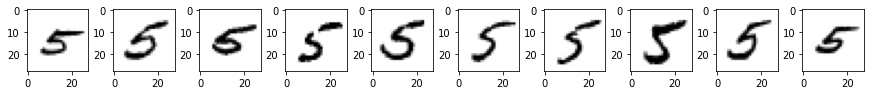

Examples for cluster 9. Most frequent label is 3.


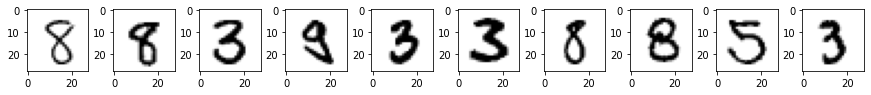

In [33]:
plot_clustering_examples(results)

#### 4.4 Normalized Spectral Clustering - $L_{sym}$

C:\Users\alexa\anaconda3\envs\msc\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\alexa\anaconda3\envs\msc\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\alexa\anaconda3\envs\msc\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\alexa\anaconda3\envs\msc\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral emb

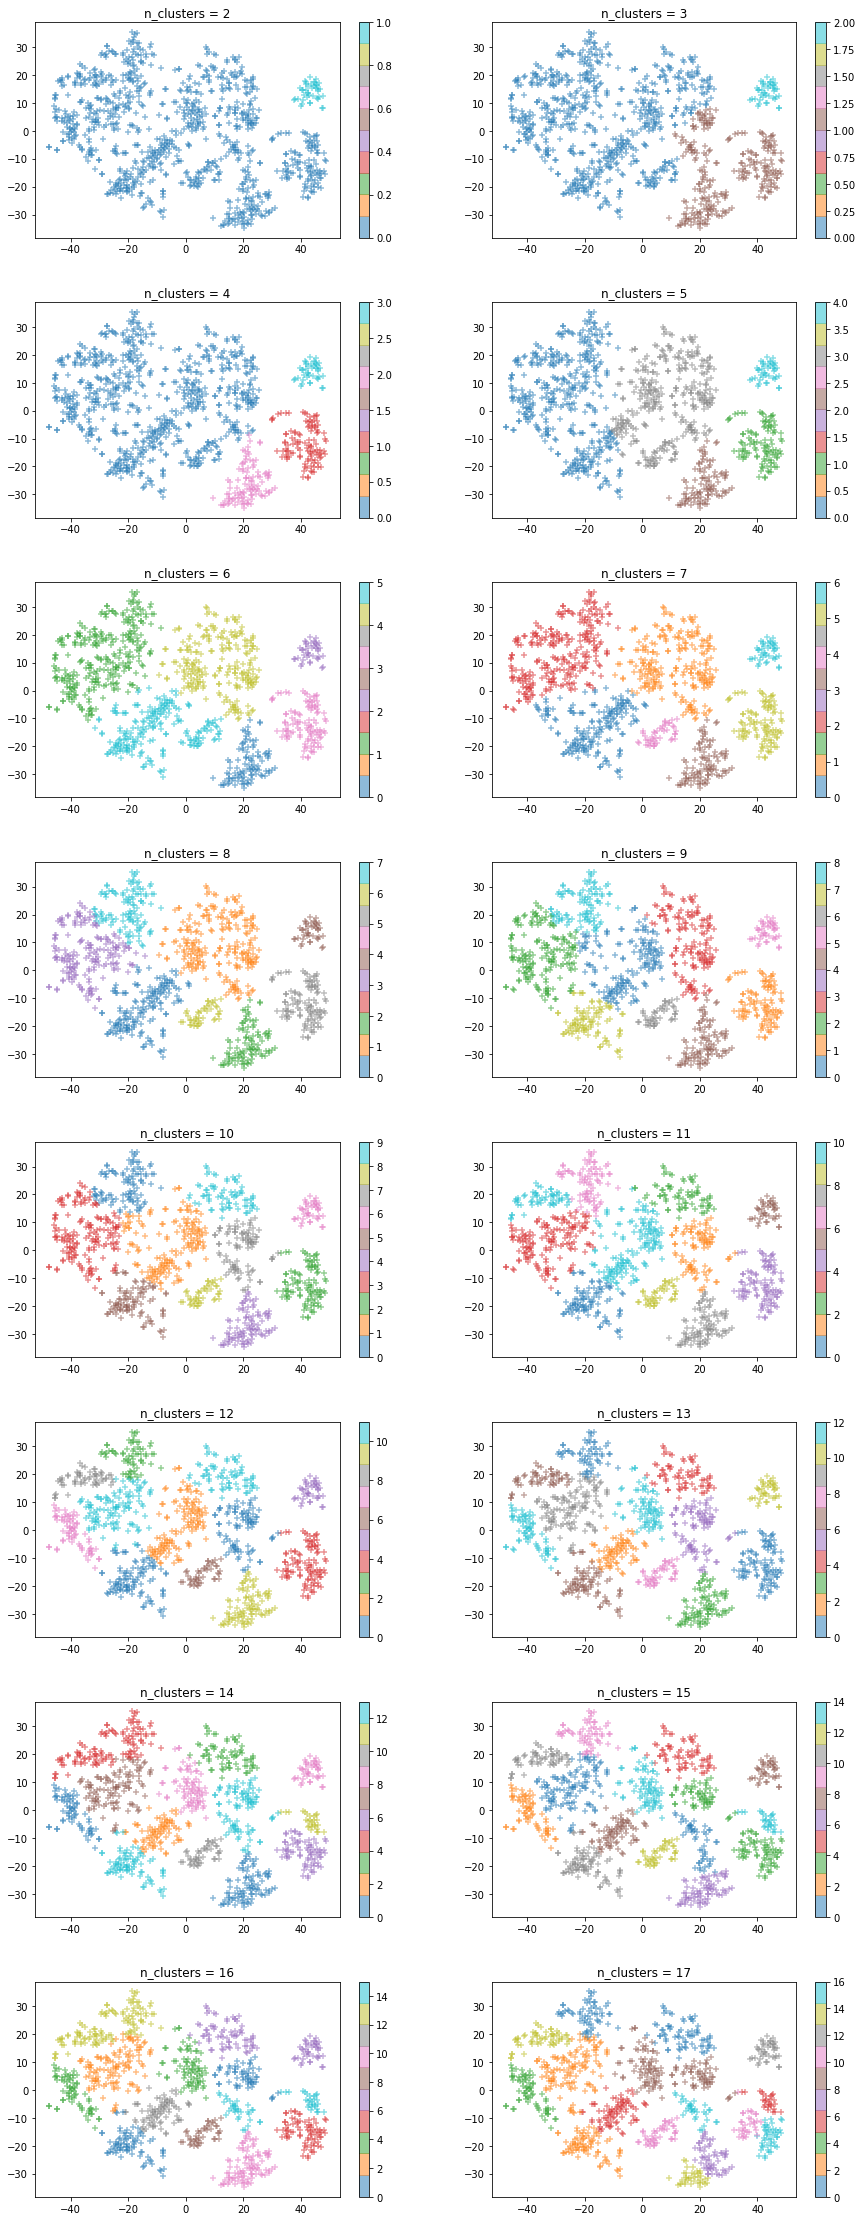

In [34]:
from sklearn.cluster import SpectralClustering

clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=20, random_state=0, n_jobs=-1)

results = do_the_clustering(clustering, x_train_embedded, y_train)

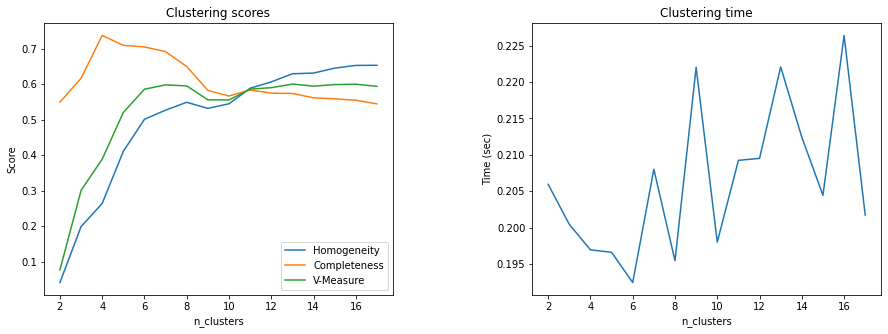

In [35]:
plot_clustering_results(results)

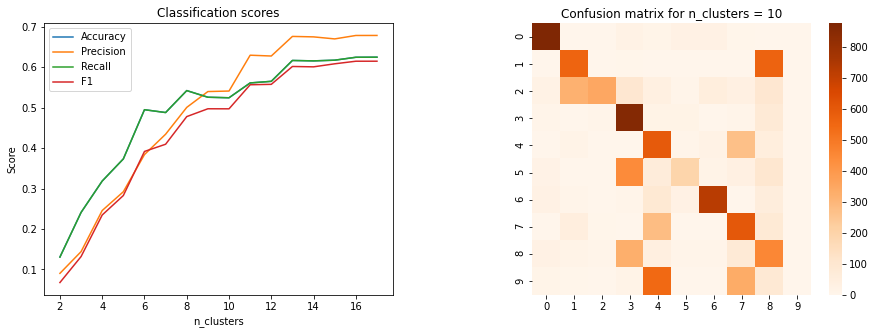

In [36]:
plot_classification_results(results)

In [37]:
display_scores(results)

n_clusters,Homogeneity,Completeness,V-Measure,Accuracy,Precision,Recall,F1
2,0.041583,0.549487,0.077314,0.1307,0.090477,0.1307,0.067764
3,0.199007,0.616718,0.300913,0.2409,0.144080,0.2409,0.131882
4,0.264313,0.737282,0.389126,0.3184,0.245619,0.3184,0.234569
5,0.411095,0.709517,0.520571,0.3731,0.292016,0.3731,0.282623
6,0.501254,0.704933,0.585897,0.4946,0.383788,0.4946,0.391532
7,0.526991,0.691598,0.598177,0.4876,0.434062,0.4876,0.409305
8,0.549123,0.649742,0.595210,0.5418,0.500339,0.5418,0.477589
9,0.531926,0.582446,0.556040,0.5254,0.539437,0.5254,0.496912
10,0.544949,0.566799,0.555660,0.5241,0.540686,0.5241,0.496783
11,0.588626,0.583704,0.586155,0.5607,0.629202,0.5607,0.556229


Clustering examples for n_clusters = 10

Examples for cluster 0. Most frequent label is 4.


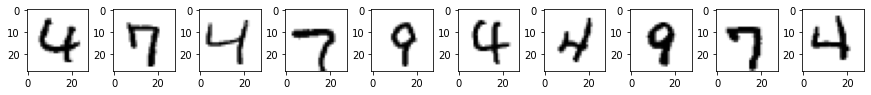

Examples for cluster 1. Most frequent label is 8.


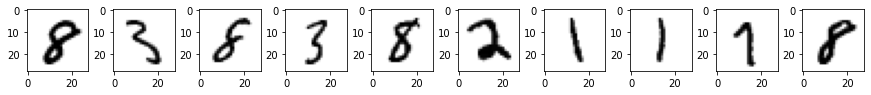

Examples for cluster 2. Most frequent label is 0.


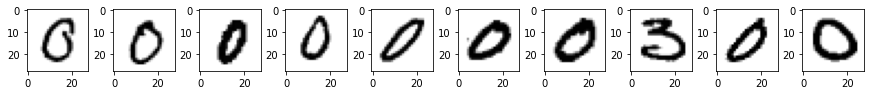

Examples for cluster 3. Most frequent label is 7.


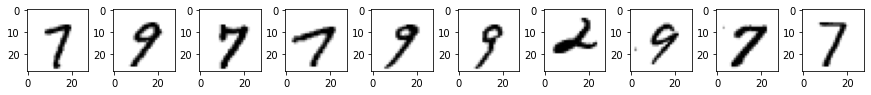

Examples for cluster 4. Most frequent label is 6.


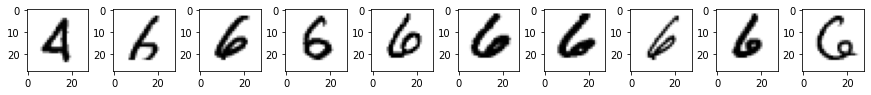

Examples for cluster 5. Most frequent label is 1.


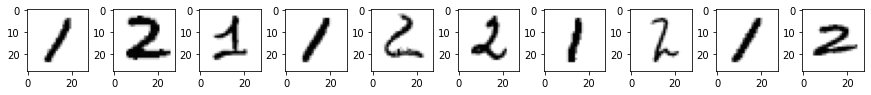

Examples for cluster 6. Most frequent label is 2.


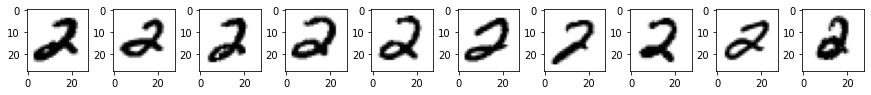

Examples for cluster 7. Most frequent label is 3.


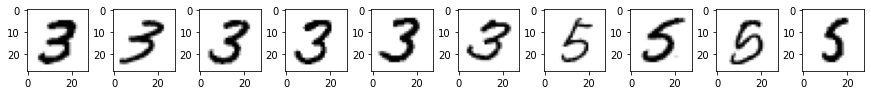

Examples for cluster 8. Most frequent label is 5.


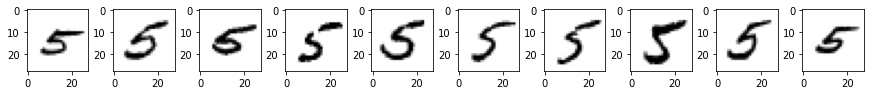

Examples for cluster 9. Most frequent label is 3.


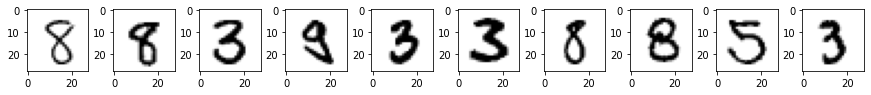

In [38]:
plot_clustering_examples(results)